## Homework 2: Spread Trading
### FINM 33150 (Winter 2025) - Quantitative Trading Strategies
#### NAME: Arturo Charleston
#### Student ID: 12449584

### Introduction

In this notebook we implement a spread-reversion trading strategy. The strategy enters or maintains a position if the size difference (spread) between the M-day return on two ETFs, X and Y is greater than a hyperparameter g. It exits the position when the spread crosses back below j $(j<g)$, and includes a stop loss if the gross notional of the position has lost more than a proportion s of the gross traded cash $(|$long| + |$short|)$. 

The ETFs used in this spread trading are
1. X (RTH: VanEck Retail ETF) "To be initially eligible for the index, companies must generate at least 50% of their revenues from retail. Retail includes companies engaged primarily in retail distribution; wholesalers; online, direct mail and TV retailers; multi-line retailers; specialty retailers; and food and other staples retailers. The fund is non-diversified."
2. Y: (XRT SPDR S&P Retail ETF) "Tracks the performance of the S&P Retail Select Industry Index. The index represents the retail segment of the S&P Total Market Index ("S&P TMI")."

Both ETFs belong to the retail sector and they should have similar performance. This represents a good pair to build a spread reversion trading strategy. 
The following sections download the data required, clean it, and implement the trading strategy, and try different parameters to maximize performance measured as the cumulative profit and loss. 

To track performance, the trading strategy returns on capital will also be compared with the returns of the Fama-French 3 factor model (Market, Size, and Value factors), and an ETF that measures volatility $SVOL. 


In [34]:
# PACKAGES
import os
import nasdaqdatalink
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

# Global Options
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.display.float_format = '{:.5f}'.format

# Set directory
home_directory = "/Users/charleston/Downloads/git_repositories/finm-qts-2025"
os.chdir(home_directory)

# Set keys
from config import QUANDL_KEY
quandl_keys = QUANDL_KEY
nasdaqdatalink.ApiConfig.api_key = quandl_keys

# Set dates
start_date = '2022-12-02'
end_date = '2024-11-15'

tickers = "SVOL,RTH,XRT"

## Functions

In [35]:
# Calculate trading strategy
def trading_strategy(etf_spread, capital, start_trading, end_trading, 
                     g=0.028, j=0.07, trading_costs=0.00001, stop_loss_pct=0.15):
    """
    Implement a trading strategy for ETF spread trading
    
    Parameters:
    -----------
    etf_spread : pandas.DataFrame
        DataFrame containing trading data with columns:
        - z: z-score of the spread
        - RTH_adj_close: Adjusted closing price for RTH
        - XRT_adj_close: Adjusted closing price for XRT
        - n_t: Median Daily Volume
    capital : float
        Initial trading capital
    start_trading : str or pd.Timestamp
        Start date for trading
    end_trading : str or pd.Timestamp
        End date for trading
    g : float, optional
        Entry threshold (default: 1.5)
    j : float, optional
        Exit threshold (default: 0.5)
    trading_costs : float, optional
        Transaction cost percentage (default: 0.1%)
    stop_loss_pct : float, optional
        Stop loss percentage (default: 2%)
    
    Returns:
    --------
    pandas.DataFrame
        Modified DataFrame with trading results
    """
    # Initialize tracking variables
    current_position = None  # "long_spread", "short_spread" or None
    cash = capital  # Current available cash
    pnl = 0  # Cumulative profit and loss
    blocked_until = pd.Timestamp("1900-01-01")  # No blocking initially
    num_shares_RTH = 0
    num_shares_XRT = 0
    initial_price_RTH = 0
    initial_price_XRT = 0

    # Create a copy of the DataFrame to avoid modifying the original
    etf_spread = etf_spread.copy()

    # Add new columns for tracking
    etf_spread['current_position'] = None
    etf_spread['num_shares_RTH'] = 0
    etf_spread['num_shares_XRT'] = 0
    etf_spread['cash_traded'] = 0
    etf_spread['transaction_costs'] = 0
    etf_spread['daily_pnl'] = 0
    etf_spread['pnl'] = 0
    etf_spread['cash'] = 0
    etf_spread['stop_loss_day'] = None

    # Iterate through the data to implement the strategy
    for i, row in etf_spread.loc[start_trading:end_trading].iterrows():
        z = row['z']
        RTH_price = row['RTH_adj_close']
        XRT_price = row['XRT_adj_close']
        Nt = row['n_t']  # Median Daily Volume
        position_value_RTH = num_shares_RTH * RTH_price
        position_value_XRT = num_shares_XRT * XRT_price
        total_position_value = abs(position_value_RTH) + abs(position_value_XRT)

        # Block trading once stop loss is hit (if blocked_until has been updated)
        if pd.Timestamp(i) < blocked_until:
            etf_spread.loc[i:, 'num_shares_RTH'] = 0
            etf_spread.loc[i:, 'num_shares_XRT'] = 0
            current_position = None
            etf_spread.loc[i, 'current_position'] = str(current_position)
            continue

        # Calculate daily P&L (Position P&L change from the previous day)
        daily_pnl = (num_shares_RTH * (RTH_price - initial_price_RTH) + 
                     num_shares_XRT * (XRT_price - initial_price_XRT))

        # Check stop-loss condition (using daily_pnl)
        if current_position is not None and daily_pnl < -stop_loss_pct * gross_traded:
            # Stop loss hit, closing the position
            transaction_costs = trading_costs * total_position_value
            realized_pnl = (position_value_RTH + position_value_XRT) - \
                           (initial_price_RTH * num_shares_RTH + 
                            initial_price_XRT * num_shares_XRT) - transaction_costs
            pnl += realized_pnl
            cash += (position_value_RTH + position_value_XRT) - transaction_costs

            # Close position and reset
            etf_spread.loc[i:, 'num_shares_RTH'] = 0
            etf_spread.loc[i:, 'num_shares_XRT'] = 0
            etf_spread.loc[i, 'cash_traded'] = total_position_value
            etf_spread.loc[i, 'transaction_costs'] = transaction_costs
            current_position = None
            etf_spread.loc[i, 'current_position'] = str(current_position)
            
            etf_spread.loc[i, 'daily_pnl'] = daily_pnl
            etf_spread.loc[i, 'pnl'] = pnl
            etf_spread.loc[i, 'cash'] = cash

            # Track the stop-loss day by adding the stop-loss date to the DataFrame
            etf_spread.loc[i, 'stop_loss_day'] = pd.Timestamp(i)

            # Block further trading (stop trading for a specified period, here 1 month as example)
            blocked_until = (pd.Timestamp(i) + pd.DateOffset(months=1)).replace(day=1)

            continue

        # Check exit condition (threshold reached, closing the position)
        if current_position is not None and abs(z) < j:
            # Close the position
            transaction_costs = trading_costs * total_position_value
            realized_pnl = (position_value_RTH + position_value_XRT) - \
                           (initial_price_RTH * num_shares_RTH + 
                            initial_price_XRT * num_shares_XRT) - transaction_costs
            pnl += realized_pnl
            cash += (position_value_RTH + position_value_XRT) - transaction_costs

            # Reset position in the DataFrame
            etf_spread.loc[i:, 'num_shares_RTH'] = 0
            etf_spread.loc[i:, 'num_shares_XRT'] = 0
            etf_spread.loc[i, 'cash_traded'] = total_position_value
            etf_spread.loc[i, 'transaction_costs'] = transaction_costs
            current_position = None

        elif current_position is not None and (
            (current_position == "long_spread" and z > g) or
            (current_position == "short_spread" and z < -g)
        ):
            # Close current position and open new one based on z value
            transaction_costs = trading_costs * total_position_value
            realized_pnl = (position_value_RTH + position_value_XRT) - \
                           (initial_price_RTH * num_shares_RTH + 
                            initial_price_XRT * num_shares_XRT) - transaction_costs
            pnl += realized_pnl
            cash += (position_value_RTH + position_value_XRT) - transaction_costs

            # Reset the position before opening a new one
            etf_spread.loc[i:, 'num_shares_RTH'] = 0
            etf_spread.loc[i:, 'num_shares_XRT'] = 0
            etf_spread.loc[i, 'cash_traded'] = total_position_value
            etf_spread.loc[i, 'transaction_costs'] = transaction_costs

            # Open a new position
            trade_amount = Nt / 100
            num_shares_RTH = int(trade_amount / RTH_price)
            num_shares_XRT = int(trade_amount / XRT_price)

            if z > 0:
                current_position = "short_spread"
                num_shares_RTH = -num_shares_RTH
            else:
                current_position = "long_spread"
                num_shares_XRT = -num_shares_XRT

            initial_price_RTH = RTH_price
            initial_price_XRT = XRT_price

            # Record position change and adjust cash
            position_cost_basis_RTH = num_shares_RTH * RTH_price
            position_cost_basis_XRT = num_shares_XRT * XRT_price
            gross_traded = abs(position_cost_basis_RTH) + abs(position_cost_basis_XRT)
            transaction_costs = trading_costs * gross_traded
            cash -= gross_traded + transaction_costs

            etf_spread.loc[i, 'cash_traded'] = gross_traded
            etf_spread.loc[i, 'transaction_costs'] = transaction_costs
            etf_spread.loc[i:, 'num_shares_RTH'] = num_shares_RTH
            etf_spread.loc[i:, 'num_shares_XRT'] = num_shares_XRT

        # Check entry condition (enter if no position)
        elif current_position is None and abs(z) > g:
            trade_amount = Nt / 100
            num_shares_RTH = int(trade_amount / RTH_price)
            num_shares_XRT = int(trade_amount / XRT_price)

            # Open spread based on z direction
            if z > 0:
                current_position = "short_spread"  # Short RTH, long XRT
                num_shares_RTH = -num_shares_RTH
            else:
                current_position = "long_spread"  # Long RTH, short XRT
                num_shares_XRT = -num_shares_XRT

            # Record cost basis and cash adjustment
            initial_price_RTH = RTH_price
            initial_price_XRT = XRT_price
            position_cost_basis_RTH = num_shares_RTH * RTH_price
            position_cost_basis_XRT = num_shares_XRT * XRT_price
            gross_traded = abs(position_cost_basis_RTH) + abs(position_cost_basis_XRT)
            transaction_costs = trading_costs * gross_traded
            cash -= gross_traded + transaction_costs  # Deduct trade cash

            etf_spread.loc[i, 'cash_traded'] = gross_traded
            etf_spread.loc[i, 'transaction_costs'] = transaction_costs

            # Save position
            etf_spread.loc[i:, 'num_shares_RTH'] = num_shares_RTH
            etf_spread.loc[i:, 'num_shares_XRT'] = num_shares_XRT

        # Track daily P&L for daily performance monitoring
        etf_spread.loc[i, 'daily_pnl'] = daily_pnl

        # Update DataFrame with cumulative P&L and cash
        etf_spread.loc[i, 'current_position'] = str(current_position)
        etf_spread.loc[i, 'pnl'] = pnl
        etf_spread.loc[i, 'cash'] = cash

    return etf_spread.loc[start_trading:end_trading, 'n_t':]

# Calculate summary regression statistics
def calc_regression_summary(y, x, include_constant=True, adj_factor=12):
    """
    Perform OLS regression and return a summary of the results and some metrics.

    Args:
        y (pd.Series): Target variable.
        x (pd.DataFrame): Predictor variables.
        include_constant (bool, optional): Whether to include a constant term in the regression. Defaults to True.

    Returns:
        pd.DataFrame: DataFrame containing the regression summary including Alpha, R-squared, Betas, Information Ratio, Tracking Error, Correlation, and Mean Fitted.
    """
    import statsmodels.api as sm

    if include_constant:
        x = sm.add_constant(x)
    
    # Fit the OLS model
    ols = sm.OLS(y, x, missing='drop').fit()
    
    # Extract results
    intercept = adj_factor*ols.params.iloc[0] if include_constant else 0
    betas = ols.params.iloc[1:] if include_constant else ols.params
    r2 = ols.rsquared
    tracking_error = ols.resid.std() * np.sqrt(adj_factor)
    information_ratio = (intercept / tracking_error) * np.sqrt(adj_factor) if tracking_error != 0 else np.nan
    correlation = y.corr(ols.fittedvalues)
    mean_fitted = ols.fittedvalues.mean() * adj_factor
   
    # Create a DataFrame for all the requested information
    summary_df = pd.DataFrame({
        'Value': [intercept, r2] + betas.tolist() + [information_ratio, tracking_error, correlation, mean_fitted]
    }, index=['Alpha', 'R-squared'] + [f"{col} Beta" for col in betas.index.tolist()] + ['Information Ratio', 'Tracking Error', 'Correlation', 'Mean fitted'])
    
    return summary_df


### Data
We use daily data from four data sources detailed below.

1. SVOL (Volatility ETF)
2. X (RTH: VanEck Retail ETF)
3. Y: (XRT SPDR S&P Retail ETF)
4. Fama-French 3 factor model returns (MKT, SMB, HML)

The data compiled is from 2022-12-02 to 2024-11-15, and the trading period is from 2023-01-02 to 2024-11-15. 


In [36]:
# DATA
# Fama French Factors
ff_returns = pd.read_csv('data/F-F_Research_Data_Factors_daily.csv', delimiter=',', skiprows=4, index_col=0)
ff_returns = ff_returns[ff_returns.index.str.isnumeric()] # To remove the copyright row
ff_returns.index = pd.to_datetime(ff_returns.index, format='%Y%m%d')
ff_returns = ff_returns.loc[start_date:end_date] # Filter dates

In [37]:
# Fetch the data using date and ticker filters
# ETFs and SVOL
tickers_data = nasdaqdatalink.get_table(
    'QUOTEMEDIA/PRICES',
    date={'gte': start_date, 'lte': end_date},  # Specify start and end dates
    ticker=tickers                             # Pass the tickers
).sort_values(by='date')

### Data Preparation

- Calculate the dollar volume as $Dollar Volume = Adjusted Volume * Adjusted Close Price$
- Calculate the median dollar volume in a 15-day window
- Separate the data into different data frames per each ticker
- Calculate $N_t$ as the minimum dollar volume median in a 15 days window. $N_t = Median[{V_{t-15}, V_{t-14}, ..., V_{t-1}}]$
- Create an initial 7-day look back window to calculate the returns, and the spread in returns to generate summary statistics for the initial strategy


In [38]:
# X = RTH VanEck Retail ETF. Include big retailers like Walmart, Amazon, Home Depot, etc.
# Y = XRT SPDR S&P Retail ETF. Include Carvana, Victoria Secret, etc.  

ETFs = ['RTH', 'XRT']

tickers_data['dollar_volume'] = tickers_data['adj_close'] * tickers_data['adj_volume']
tickers_data['dollar_volume_median'] = tickers_data['dollar_volume'].rolling(window=15, min_periods=15).median()

for ticker in ETFs:
    globals()[ticker] = tickers_data[tickers_data['ticker'] == ticker].set_index('date')


In [39]:
columns = ['adj_close', 'adj_volume', 'dollar_volume', 'dollar_volume_median']
etf_spread = pd.concat([
    RTH[columns].add_prefix('RTH_'),
    XRT[columns].add_prefix('XRT_')
], axis=1)
etf_spread['n_t'] = etf_spread[['RTH_dollar_volume_median', 'XRT_dollar_volume_median']].min(axis=1)

In [40]:
M = 7 # Look back window
# Add column for M-day returns
etf_spread['RTH_M_return'] = etf_spread['RTH_adj_close'].pct_change(M)
etf_spread['XRT_M_return'] = etf_spread['XRT_adj_close'].pct_change(M)

# Calculate the spread (z)
etf_spread['z'] = (etf_spread['RTH_M_return'] - etf_spread['XRT_M_return'])
etf_spread['abs_z'] = etf_spread['z'].abs()

### Descriptive statistics of the spread
Given the descriptive statistics of the spread, we define the initial parameters that will be optimized in a following section to maximize cumulative profits. 

In [41]:
etf_spread[['n_t', 'RTH_M_return', 'XRT_M_return', 'z', 'abs_z']].describe()

,n_t,RTH_M_return,XRT_M_return,z,abs_z
count,487.00000,485.00000,485.00000,485.00000,485.00000
mean,11039330.92917,0.00491,0.00384,0.00107,0.01955
std,7172515.70380,0.02218,0.03686,0.02424,0.01434
min,982690.80000,-0.05625,-0.08538,-0.07918,0.00003
25%,6031654.49500,-0.00947,-0.02223,-0.01504,0.00831
50%,10175534.68000,0.00647,0.00172,0.00257,0.01677
75%,15471883.44000,0.01886,0.03026,0.01919,0.02793
max,56090062.28000,0.06320,0.12255,0.06982,0.07918


In [42]:
# Parameters
# Define how to select the optimal parameters for the strategy. DO THAT LATER
M = 7 # Look back window
g = 0.028 # Entry threshold for the spread
j = 0.008 # Exit threshold for the spread
capital =  etf_spread['n_t'].max()*2 # Initial capital
stop_loss = 0.15 # Stop loss threshold
trading_costs = 0.00001 # Trading costs
start_trading = "2023-01-02"
end_trading = "2024-11-15"

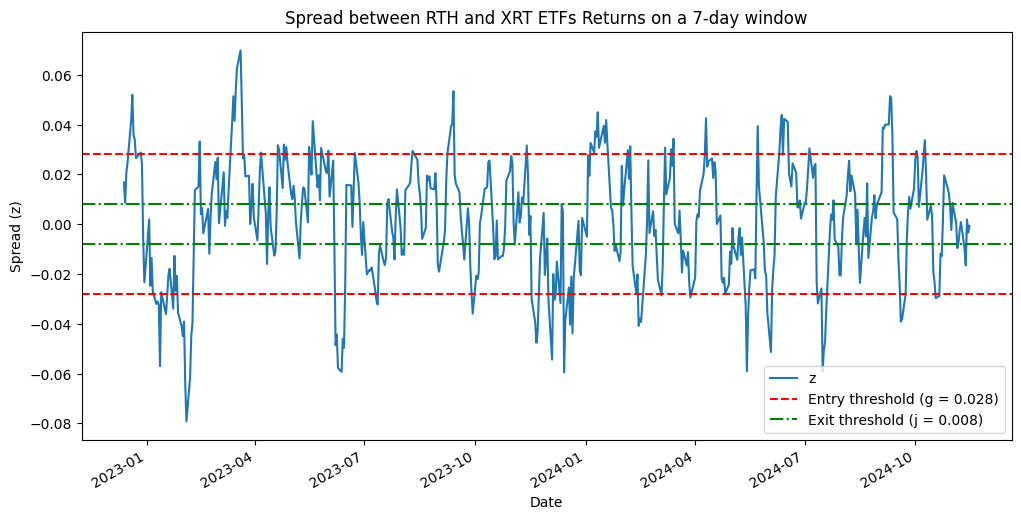

In [43]:
etf_spread['z'].plot(figsize=(12, 6), title=f"Spread between RTH and XRT ETFs Returns on a {M}-day window")
plt.axhline(y=g, color='r', linestyle='--', label=f'Entry threshold (g = {g})')
plt.axhline(y=-g, color='r', linestyle='--')
plt.axhline(y=j, color='g', linestyle='-.', label=f'Exit threshold (j = {j})')
plt.axhline(y=-j, color='g', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Spread (z)')
plt.legend()
plt.show()

## Trading Strategy Construction

The strategy is based on the following parameters that are defined in the cell below

- M: Look back window for the M-day return
- g: Entry threshold for the spread to initiate an spread trading or 'flip' the position
- j: Exit threshold to exit the trade $(j<g)$ always
- capital: Defined as two times the maximum $n_t$ as previously defined. Set to a high value to avoid liquidity problems
- trading_costs: Proportional trading cost of executing trades (0.1% or 0). It is the trading cost on the gross notional
- stop_loss: The threshold at which the positions are closed and trading is halted until the end of the month. E.g, if stop_loss if 0.10, if the PNL < - 10%, we close the position and stop trading until the first day of the next month
- start_trading: The first day of trading
- end_trading: The day at which every position is closed and no more trading happens


We will initialize the strategy with some reasonable sounding parameters based on the descriptive statistics of the spread. Then we will work around a grid close to these parameters to find the optimal parameters to maximize our pnl. 
- M: 7 days look back window
- g: 0.028 based on the 75% of the absolute value of the spread
- j: 0.07 based on the 25% of the absolute value of the spread
- trading_costs: 0.1% proportional on gross notional of the trade
- stop loss: 15% reasonable risk management assumption

In [44]:
trading_record = trading_strategy(
    etf_spread=etf_spread,
    capital=capital,
    trading_costs=trading_costs,
    stop_loss_pct=stop_loss,
    start_trading=start_trading,
    end_trading=end_trading,
    g=g,
    j=j
)

## Analysis of the First Strategy Parameters

From our initial parameters we can see that the spread is very volatile. There is a negative relationship between the window we use, and the volatility in the spread, as we will see in the next sections. As we increase the size of our window to calculate the spread, we reduce the volatility. 
Even though our entry and exit thresholds have a wide difference, we have significant entries given that our spread is highly volatility due to the 7-day window used. In later sections we will contrast our results with the Volatility ETF SVOL returns to see if our returns can be explained by the volatility of our positions. 

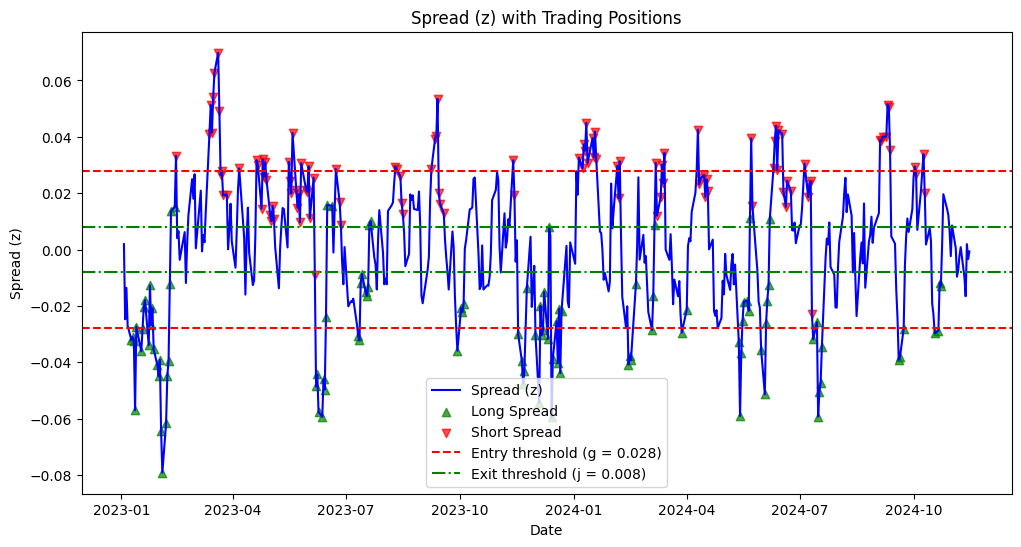

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(trading_record.index, trading_record['z'], label='Spread (z)', color='blue')

# Mark long spread positions
long_spread = trading_record[trading_record['current_position'] == 'long_spread']
plt.scatter(long_spread.index, long_spread['z'], color='green', marker='^', label='Long Spread', alpha=0.7)

# Mark short spread positions
short_spread = trading_record[trading_record['current_position'] == 'short_spread']
plt.scatter(short_spread.index, short_spread['z'], color='red', marker='v', label='Short Spread', alpha=0.7)

plt.axhline(y=g, color='r', linestyle='--', label=f'Entry threshold (g = {g})')
plt.axhline(y=-g, color='r', linestyle='--')
plt.axhline(y=j, color='g', linestyle='-.', label=f'Exit threshold (j = {j})')
plt.axhline(y=-j, color='g', linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Spread (z)')
plt.title('Spread (z) with Trading Positions')
plt.legend()
plt.show()

In [46]:
roc = trading_record['pnl'].iloc[-1] / capital

print(f"Final PnL = {trading_record['pnl'].iloc[-1]:,.2f}")
print(f"Return on Capital = {100*roc:.2f}%")

Final PnL = 41,627.20
Return on Capital = 0.04%


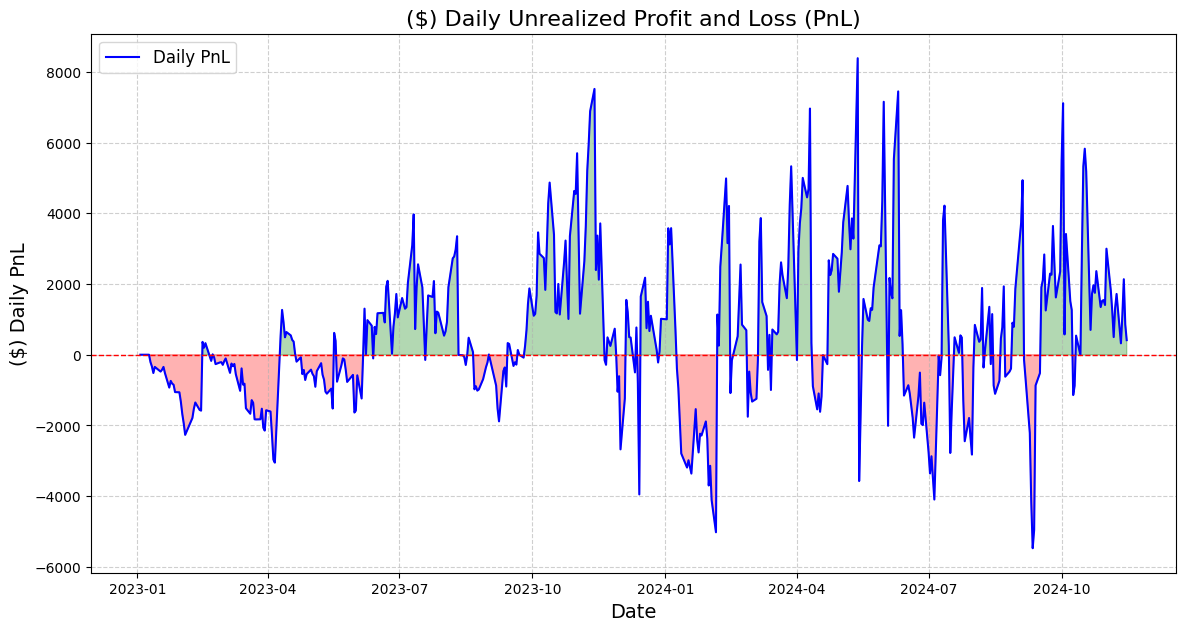

In [47]:
plt.figure(figsize=(14, 7))
plt.plot(trading_record.index, trading_record['daily_pnl'], label='Daily PnL', color='blue', linewidth=1.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title('($) Daily Unrealized Profit and Loss (PnL)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('($) Daily PnL', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight positive and negative PnL
plt.fill_between(trading_record.index, trading_record['daily_pnl'], where=(trading_record['daily_pnl'] > 0), color='green', alpha=0.3, interpolate=True)
plt.fill_between(trading_record.index, trading_record['daily_pnl'], where=(trading_record['daily_pnl'] < 0), color='red', alpha=0.3, interpolate=True)


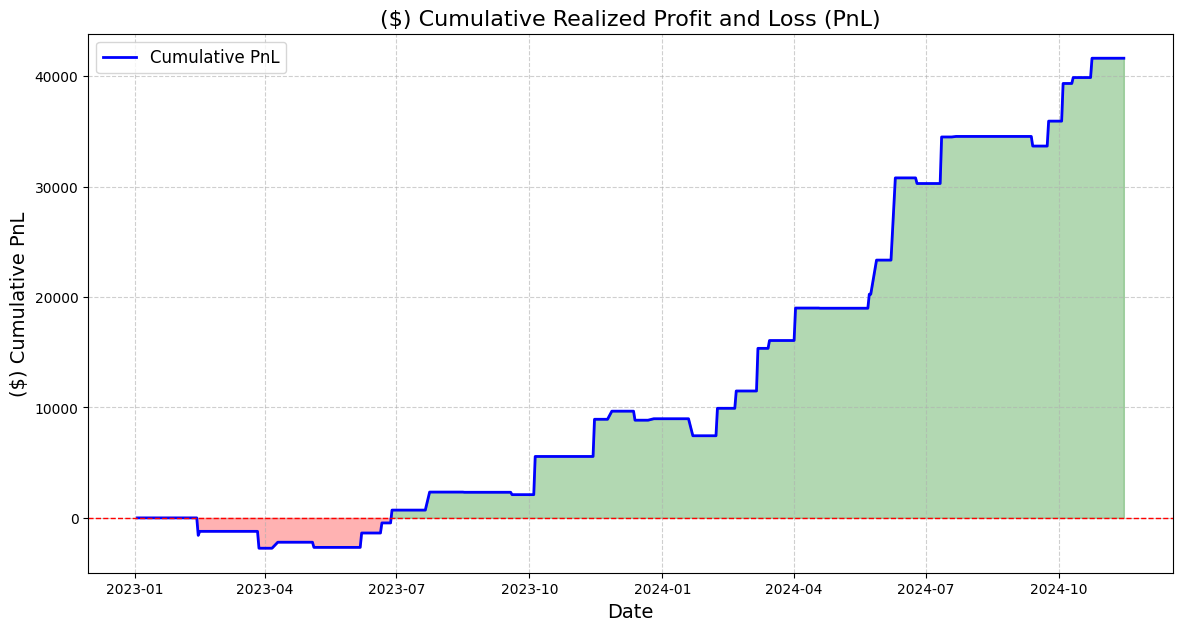

In [48]:
plt.figure(figsize=(14, 7))
plt.plot(trading_record.index, trading_record['pnl'], label='Cumulative PnL', color='blue', linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title('($) Cumulative Realized Profit and Loss (PnL)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('($) Cumulative PnL', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight positive and negative PnL
plt.fill_between(trading_record.index, trading_record['pnl'], where=(trading_record['pnl'] > 0), color='green', alpha=0.3, interpolate=True)
plt.fill_between(trading_record.index, trading_record['pnl'], where=(trading_record['pnl'] < 0), color='red', alpha=0.3, interpolate=True)

plt.show()

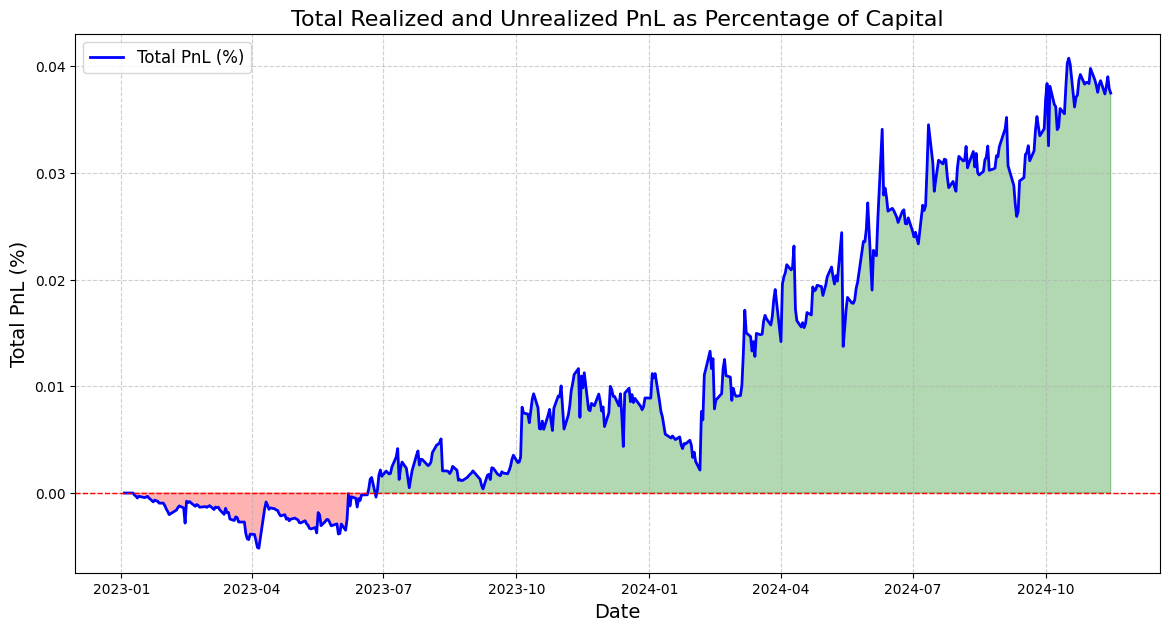

In [49]:
# Calculate the sum of realized and unrealized PnL divided by capital
trading_record['total_pnl'] = trading_record['pnl'] + trading_record['daily_pnl']
trading_record['total_pnl_percentage'] = (trading_record['total_pnl'] / capital) * 100

# Plot the total PnL percentage
plt.figure(figsize=(14, 7))
plt.plot(trading_record.index, trading_record['total_pnl_percentage'], label='Total PnL (%)', color='blue', linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title('Total Realized and Unrealized PnL as Percentage of Capital', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total PnL (%)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight positive and negative total PnL
plt.fill_between(trading_record.index, trading_record['total_pnl_percentage'], where=(trading_record['total_pnl_percentage'] > 0), color='green', alpha=0.3, interpolate=True)
plt.fill_between(trading_record.index, trading_record['total_pnl_percentage'], where=(trading_record['total_pnl_percentage'] < 0), color='red', alpha=0.3, interpolate=True)

plt.show()

## Parameter optimization
The first pass of the trading strategy gave us some idea of what a range of the optimal parameters might be. In this section, we will find the set of parameters that maximize the cumulative profit and loss, and then we will use those and the initial parameters to compare to the Fama-French factor returns, and the SVOL levels to understand how correlated our strategy is with common risk factors. 

In [50]:
# Define the parameter grid
M_values = [1, 5, 7, 10, 15, 20, 25, 30]
stop_loss_values = [0.05, 0.15, 0.20, 0.25, 0.30]
g_values = [0.02, 0.025, 0.028, 0.030, 0.035, 0.040]
j_values = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010]

# Initialize variables to track the best combination and highest P&L
best_params = None
best_pnl = float('-inf')

# Perform the grid search
for M, stop_loss, g, j in itertools.product(M_values, stop_loss_values, g_values, j_values):
    # Adjust the input DataFrame based on the parameter M
    etf_spread['RTH_M_return'] = etf_spread['RTH_adj_close'].pct_change(M)
    etf_spread['XRT_M_return'] = etf_spread['XRT_adj_close'].pct_change(M)
    etf_spread['z'] = etf_spread['RTH_M_return'] - etf_spread['XRT_M_return']
    
    # Run the strategy with the given parameters
    try:
        result = trading_strategy(
            etf_spread, 
            capital=etf_spread['n_t'].max() * 2, 
            start_trading=start_trading, 
            end_trading=end_trading, 
            g=g, 
            j=j, 
            trading_costs=0.00001, 
            stop_loss_pct=stop_loss
        )
        
        # Calculate the total P&L
        result['total_pnl'] = result['pnl'] + result['daily_pnl']
        total_pnl = result['total_pnl'].iloc[-1]  # Final P&L value
        
        # Check if this combination is better
        if total_pnl > best_pnl:
            best_pnl = total_pnl
            best_params = (M, stop_loss, g, j)
    except Exception as e:
        print(f"Error with params M={M}, stop_loss={stop_loss}, g={g}, j={j}: {e}")
        continue

# Output the best parameters and the highest P&L
print(f"Best Parameters: M={best_params[0]}, Stop Loss={best_params[1]}, g={best_params[2]}, j={best_params[3]}")
print(f"Highest P&L: {best_pnl}")


Best Parameters: M=30, Stop Loss=0.05, g=0.02, j=0.008
Highest P&L: 55325.612940933264


### Analysis of the Optimal Strategy

We can note that once we expand the window to the optimal size window of 30 days, we have a more "smooth" z score compared to the initial trading parameters that had substantial volatility. In addition, given this change in the volatility of the spread, even when we reduced the entry threshold, we enter fewer positions compared to the initial analysis.

In [51]:
etf_spread_optimal = etf_spread[['RTH_adj_close', 'XRT_adj_close', 'n_t']].copy(deep=True)
M = best_params[0] # Look back window
# Add column for M-day returns
etf_spread_optimal['RTH_M_return'] = etf_spread_optimal['RTH_adj_close'].pct_change(M)
etf_spread_optimal['XRT_M_return'] = etf_spread_optimal['XRT_adj_close'].pct_change(M)

# Calculate the spread (z)
etf_spread_optimal['z'] = (etf_spread_optimal['RTH_M_return'] - etf_spread_optimal['XRT_M_return'])

In [52]:
optimal_trading_record = trading_strategy(
    etf_spread=etf_spread_optimal,
    capital=capital,
    trading_costs=trading_costs,
    stop_loss_pct=best_params[1],
    start_trading=start_trading,
    end_trading=end_trading,
    g=best_params[2],
    j=best_params[3]
)

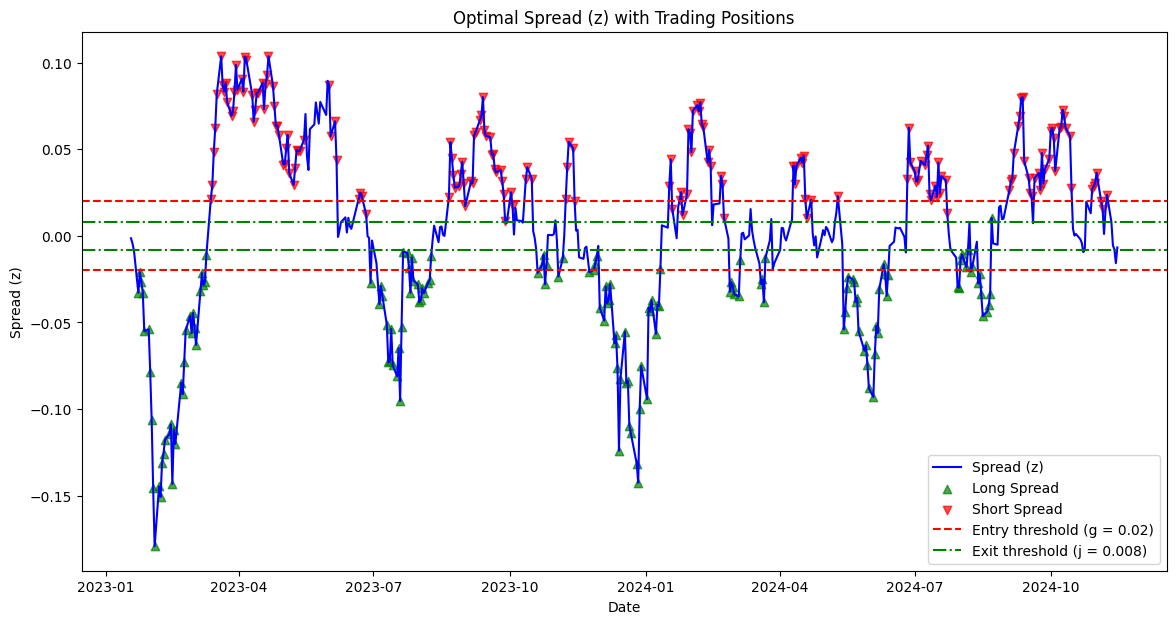

In [53]:
plt.figure(figsize=(14, 7))
plt.plot(optimal_trading_record.index, optimal_trading_record['z'], label='Spread (z)', color='blue')

# Mark long spread positions
long_spread_optimal = optimal_trading_record[optimal_trading_record['current_position'] == 'long_spread']
plt.scatter(long_spread_optimal.index, long_spread_optimal['z'], color='green', marker='^', label='Long Spread', alpha=0.7)

# Mark short spread positions
short_spread_optimal = optimal_trading_record[optimal_trading_record['current_position'] == 'short_spread']
plt.scatter(short_spread_optimal.index, short_spread_optimal['z'], color='red', marker='v', label='Short Spread', alpha=0.7)

plt.axhline(y=best_params[2], color='r', linestyle='--', label=f'Entry threshold (g = {best_params[2]})')
plt.axhline(y=-best_params[2], color='r', linestyle='--')
plt.axhline(y=best_params[3], color='g', linestyle='-.', label=f'Exit threshold (j = {best_params[3]})')
plt.axhline(y=-best_params[3], color='g', linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Spread (z)')
plt.title('Optimal Spread (z) with Trading Positions')
plt.legend()
plt.show()

In [54]:
roc = optimal_trading_record['pnl'].iloc[-1] / capital

print(f"Final PnL = {optimal_trading_record['pnl'].iloc[-1]:,.2f}")
print(f"Return on Capital = {100*roc:.2f}%")

Final PnL = 53,017.50
Return on Capital = 0.05%


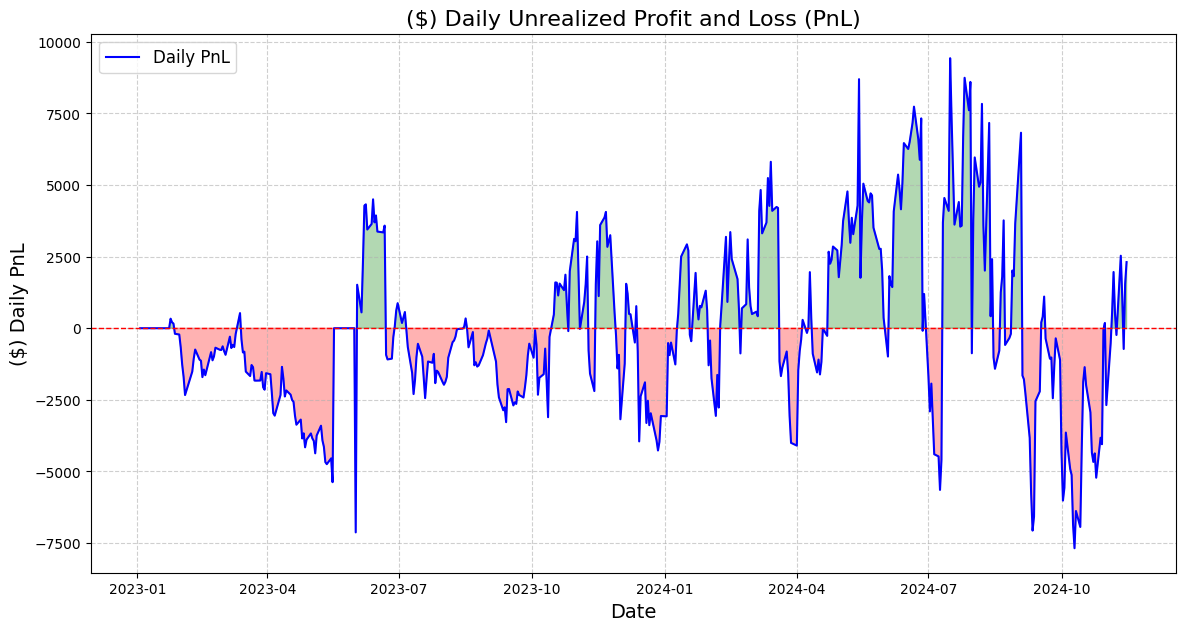

In [55]:
plt.figure(figsize=(14, 7))
plt.plot(optimal_trading_record.index, optimal_trading_record['daily_pnl'], label='Daily PnL', color='blue', linewidth=1.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title('($) Daily Unrealized Profit and Loss (PnL)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('($) Daily PnL', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight positive and negative PnL
plt.fill_between(optimal_trading_record.index, optimal_trading_record['daily_pnl'], where=(optimal_trading_record['daily_pnl'] > 0), color='green', alpha=0.3, interpolate=True)
plt.fill_between(optimal_trading_record.index, optimal_trading_record['daily_pnl'], where=(optimal_trading_record['daily_pnl'] < 0), color='red', alpha=0.3, interpolate=True)

plt.show()


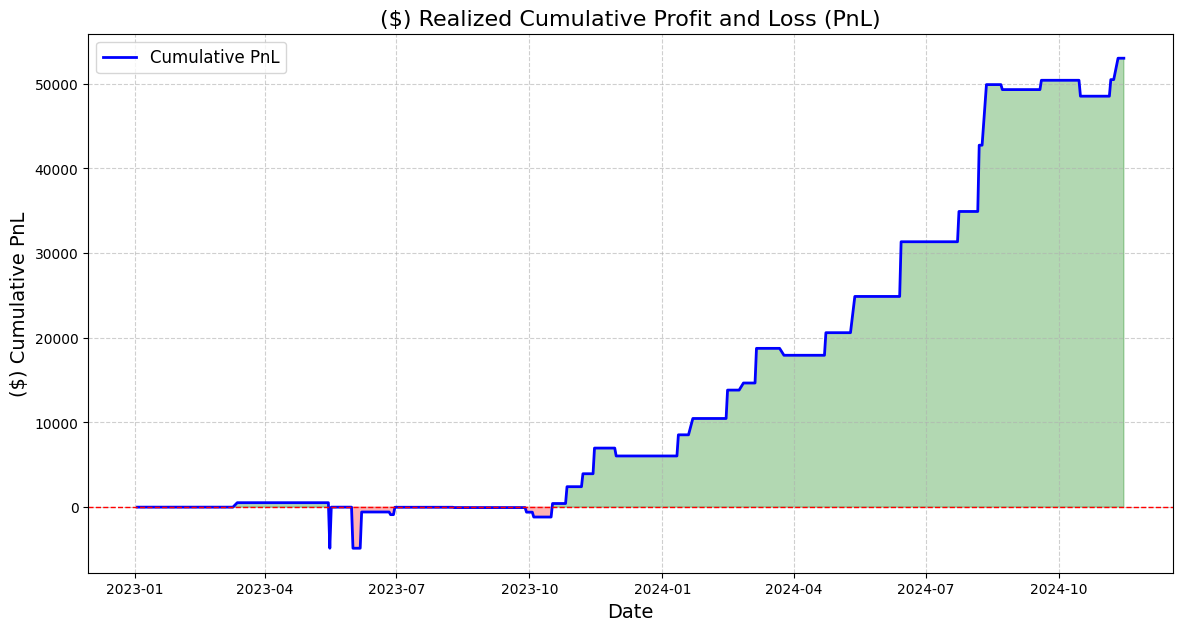

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(optimal_trading_record.index, optimal_trading_record['pnl'], label='Cumulative PnL', color='blue', linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title('($) Realized Cumulative Profit and Loss (PnL)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('($) Cumulative PnL', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight positive and negative PnL
plt.fill_between(optimal_trading_record.index, optimal_trading_record['pnl'], where=(optimal_trading_record['pnl'] > 0), color='green', alpha=0.3, interpolate=True)
plt.fill_between(optimal_trading_record.index, optimal_trading_record['pnl'], where=(optimal_trading_record['pnl'] < 0), color='red', alpha=0.3, interpolate=True)

plt.show()

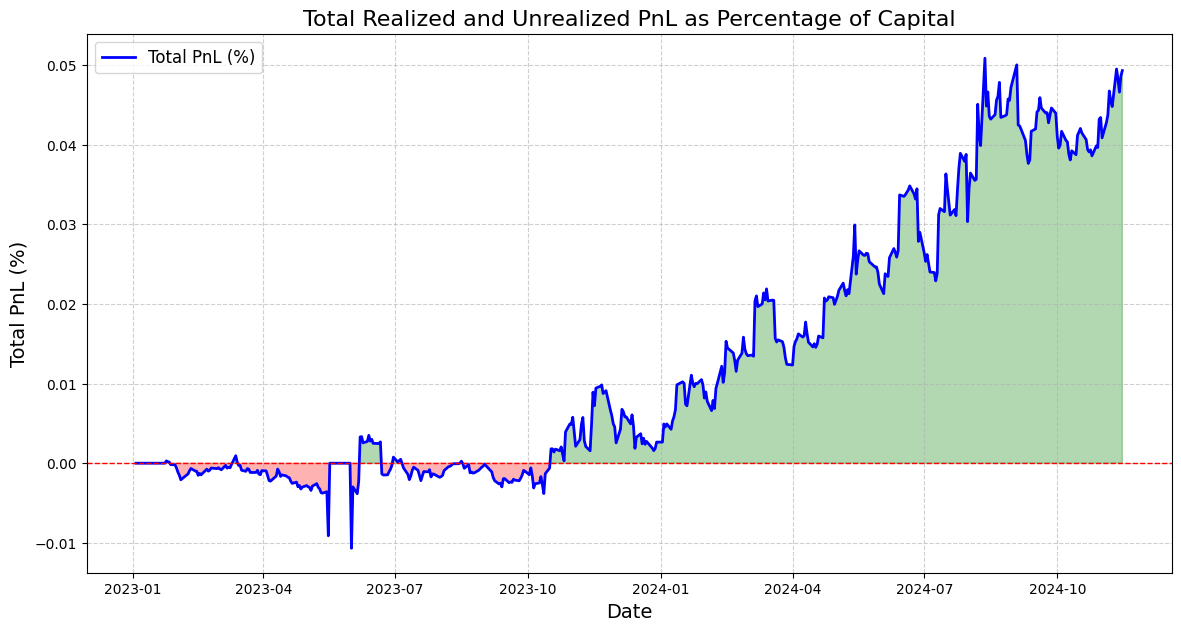

In [57]:
# Calculate the sum of realized and unrealized PnL divided by capital
optimal_trading_record['total_pnl'] = optimal_trading_record['pnl'] + optimal_trading_record['daily_pnl']
optimal_trading_record['total_pnl_percentage'] = (optimal_trading_record['total_pnl'] / capital) * 100

# Plot the total PnL percentage
plt.figure(figsize=(14, 7))
plt.plot(optimal_trading_record.index, optimal_trading_record['total_pnl_percentage'], label='Total PnL (%)', color='blue', linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title('Total Realized and Unrealized PnL as Percentage of Capital', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total PnL (%)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight positive and negative total PnL
plt.fill_between(optimal_trading_record.index, optimal_trading_record['total_pnl_percentage'], where=(optimal_trading_record['total_pnl_percentage'] > 0), color='green', alpha=0.3, interpolate=True)
plt.fill_between(optimal_trading_record.index, optimal_trading_record['total_pnl_percentage'], where=(optimal_trading_record['total_pnl_percentage'] < 0), color='red', alpha=0.3, interpolate=True)

plt.show()

## Strategy correlation with Fama French and Volatility ETF SVOL

The three Fama French factors considered in this analysis are
- Market (MKT): Excess return of the market over the risk-free rate.
- SMB (Small Minus Big): Return difference between small-cap and large-cap stocks.
- HML (High Minus Low): Return difference between value (high book-to-market) and growth (low book-to-market) stock

The comparison with these returns is important because it highlights if our strategy provides alpha, or if it is captured by exposition to these systematic risks. 

The volatility ETF SVOL is important in this context because as we saw in the initial strategy, the Z-Score is highly volatile, and given this, our returns might be substantially explained by its volatility. 


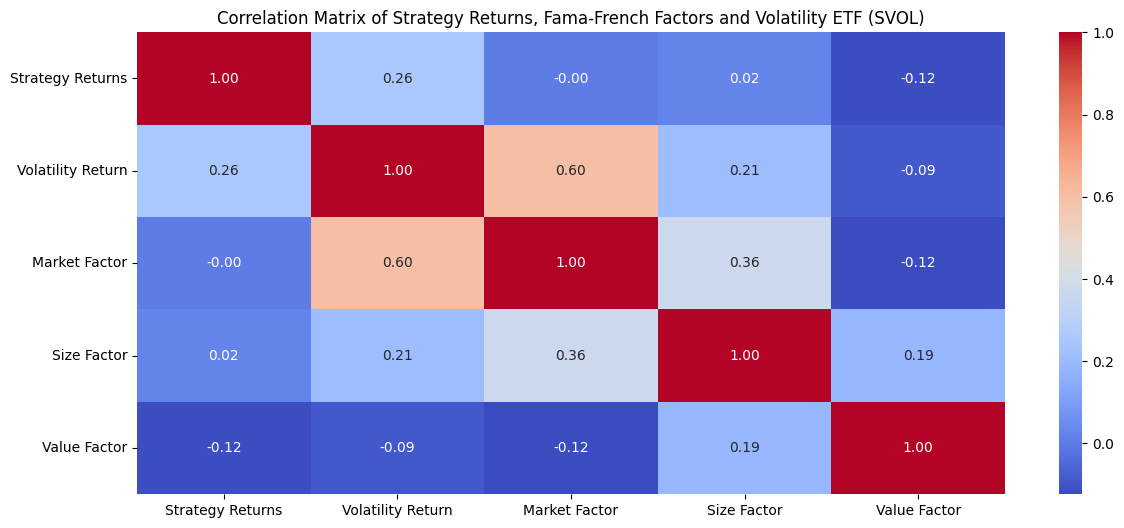

In [58]:
# Calculate daily returns for the optimal trading strategy
optimal_trading_record['strategy_return'] = (optimal_trading_record['total_pnl']/capital) - ff_returns['RF']

# Calculate daily returns for SVOL
svol_returns = tickers_data[tickers_data['ticker'] == 'SVOL'].set_index('date')['adj_close'].pct_change().rename('SVOL_return')
svol_returns = svol_returns - ff_returns['RF']

# Combine all returns into a single DataFrame
combined_returns = pd.concat([
    optimal_trading_record['strategy_return'].rename('optimal_strategy_return'),
    svol_returns.rename('volatility_return'),
    ff_returns[['Mkt-RF', 'SMB', 'HML']]
], axis=1).dropna()

combined_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_returns.dropna(inplace=True)
combined_returns

plt.figure(figsize=(14, 6))
sns.heatmap(combined_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f', 
            xticklabels=['Strategy Returns', 'Volatility Return', 'Market Factor', 'Size Factor', 'Value Factor'],
            yticklabels=['Strategy Returns', 'Volatility Return', 'Market Factor', 'Size Factor', 'Value Factor'])
plt.title('Correlation Matrix of Strategy Returns, Fama-French Factors and Volatility ETF (SVOL)')
plt.show()

In [59]:
# Combine both summaries into a single DataFrame
regression_summary = pd.concat(
    [calc_regression_summary(combined_returns['optimal_strategy_return'], combined_returns[['Mkt-RF', 'SMB', 'HML']]),
      calc_regression_summary(combined_returns['optimal_strategy_return'], combined_returns[['volatility_return']])], axis=1
)
regression_summary.columns = ['Fama-French Factors', 'Volatility ETF']

regression_summary

,Fama-French Factors,Volatility ETF
Alpha,-0.23653,-0.22106
R-squared,0.01683,0.06514
Mkt-RF Beta,-0.00009,NaN
SMB Beta,0.00016,NaN
HML Beta,-0.00033,NaN
Information Ratio,-125.43016,-120.22040
Tracking Error,0.00653,0.00637
Correlation,0.12972,0.25522
Mean fitted,-0.23653,-0.23653
volatility_return Beta,NaN,0.06499


## Analysis of the results

- The implementation of our trading strategy using spread-reversion did not provided substantial returns on capital. However, this can be explained by the very large capital available to trade. The strategy provide diversification benefits given its low (almost zero) correlation with the traditional Fama-French risk factors. Volatility had a relatively big size Beta in the regression of our returns and SVOL ETF. 
- On both regressions, we have a large negative Alpha, meaning that the strategy provides negative returns that are not explained by the risk factors. 
- Overall, given the large amount of capital, the strategy provides poor results, despite parameter optimization, indicating limited economic viability.
- The assumptions and idea behind the strategy, are academically correct. However, given its poor returns on capital, it has limited practical applications.